<a href="https://colab.research.google.com/github/pratapponnam/ProstateDetection/blob/main/CNN_for_10_patients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 18.0 MB/s eta 0:00:00


In [24]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import os
import pydicom
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [34]:
# Paths to data files
findings_train_path = "/content/drive/MyDrive/ProstateX-Findings-Train1.csv"
images_train_path = "/content/drive/MyDrive/ProstateX-Images-Train1.csv"
dicom_dir = "/content/drive/MyDrive/Prostate/"  # Update this path

# Load CSV files
findings_df = pd.read_csv(findings_train_path)
images_df = pd.read_csv(images_train_path)

# Merge the Findings and Images data
merged_df = pd.merge(images_df, findings_df, on=["ProxID", "fid"], how="inner")

# Select relevant columns
merged_df = merged_df[["ProxID", "fid", "DCMSerDescr", "DCMSerNum", "ijk", "ClinSig"]]
merged_df["ClinSig"] = merged_df["ClinSig"].fillna(0).astype(int)


In [30]:
import glob
# Function to load DICOM images based on matched series descriptions
def load_relevant_dicom_images(dicom_dir, merged_df, img_size=(128, 128)):
    images = []
    labels = []
    matched_records = 0

    # Get all DICOM file paths using glob
    dicom_files = glob.glob(os.path.join(dicom_dir, "**/*.dcm"), recursive=True)
    print(f"Found {len(dicom_files)} DICOM files.")
    if len(dicom_files) == 0:
        print("No DICOM files found. Check the directory path.")
        return np.array(images), np.array(labels)

    for _, row in merged_df.iterrows():
        series_desc = row["DCMSerDescr"]
        series_num = row["DCMSerNum"]
        label = row["ClinSig"]

        matched = False  # Flag to prevent unnecessary looping
        for dicom_path in dicom_files:
            dicom = pydicom.dcmread(dicom_path)

            if dicom.SeriesNumber == series_num and series_desc in dicom.SeriesDescription:
                img = dicom.pixel_array
                img = img.astype(np.float32)
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                img = np.expand_dims(img, axis=-1)  # Ensure 3D format (H, W, 1)
                img = tf.image.resize(img, img_size)

                images.append(img.numpy())
                labels.append(label)
                matched_records += 1
                matched = True
                break  # Stop checking once a match is found

        if not matched:
            print(f"No match found for SeriesNumber {series_num} and Description {series_desc}")

    print(f"Total matched records: {matched_records}")
    return np.array(images), np.array(labels)

In [35]:

# Load dataset
img_size = (128, 128)
X, y = load_relevant_dicom_images(dicom_dir, merged_df, img_size)

Found 9988 DICOM files.
Total matched records: 187


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 692ms/step - accuracy: 0.6988 - loss: 0.6428 - val_accuracy: 0.8421 - val_loss: 0.5520
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 433ms/step - accuracy: 0.7324 - loss: 0.5824 - val_accuracy: 0.8421 - val_loss: 0.4691
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 423ms/step - accuracy: 0.6688 - loss: 0.6547 - val_accuracy: 0.8421 - val_loss: 0.5428
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - accuracy: 0.7134 - loss: 0.5947 - val_accuracy: 0.8421 - val_loss: 0.4717
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 521ms/step - accuracy: 0.7285 - loss: 0.5584 - val_accuracy: 0.8421 - val_loss: 0.5492
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 424ms/step - accuracy: 0.7245 - loss: 0.5675 - val_accuracy: 0.8421 - val_loss: 0.5138
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step - accuracy: 0.7227 - loss: 0.5658 - val_accuracy: 0.8421 - val_loss: 0.5382
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 426ms/step - accuracy: 0.7452 - loss: 0.5232 - val_accuracy: 0.8421 - val

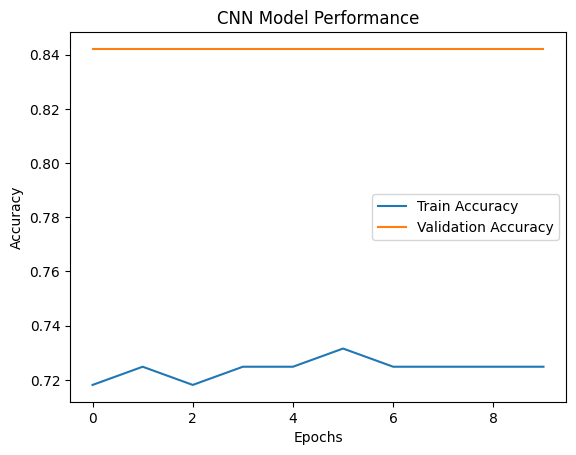

In [36]:
# One-hot encode labels
y = to_categorical(y, 2)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN Model
def build_cnn_model(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build and train CNN model
model = build_cnn_model(input_shape=(128, 128, 1), num_classes=2)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=16)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("CNN Model Performance")
plt.show()

# Save the model
model.save("dicom_cnn_model.h5")


In [37]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("dicom_cnn_model.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [39]:
import pydicom
import numpy as np
import tensorflow as tf

def preprocess_dicom(dicom_path, img_size=(128, 128)):
    dicom = pydicom.dcmread(dicom_path)
    img = dicom.pixel_array

    # Normalize pixel values
    img = img.astype(np.float32)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))

    # Add channel dimension before resizing
    img = np.expand_dims(img, axis=-1)

    # Resize image
    img = tf.image.resize(img, img_size).numpy()

    # Expand dimensions for CNN input format (batch, height, width, channels)
    img = np.expand_dims(img, axis=0)   # Add batch dimension

    return img

# Example usage with a test DICOM file
test_dicom_path = "/content/drive/MyDrive/ProstateX-0027/10-28-2011-NA-MR prostaat kanker detectie NDmc MCAPRODETN-35489/3.000000-t2tsesag-55714/1-01.dcm"
test_image = preprocess_dicom(test_dicom_path)


In [40]:
# Make prediction
predictions = model.predict(test_image)

# Get predicted class (0 = Not Clinically Significant, 1 = Clinically Significant)
predicted_class = np.argmax(predictions)

# Print results
print(f"Predicted class: {predicted_class}")
print(f"Prediction confidence: {predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
Predicted class: 0
Prediction confidence: [[0.81612945 0.18387055]]
